# Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared,
    ConstantKernel,
)

# Dataset and Preprocessing
First, we will load our datasets and do some preprocessing 🚿

This includes type casting and identifiying outliers. It is also worth thinking about normalizing your data for multiple reasons:
1. In common Gaussian processes regression models, we suppose that output `y` has zero mean, so we should standardize `y`
to match our assumption.
2. For many covariance functions, we have scaled parameters. So, we should standardize inputs to get better estimations of parameters of covariance functions.
3. Gaussian processes regression is prone to numerical problems as we have to inverse ill-conditioned covariance matrices. To make this problem less severe, you should standardize your data.

However, we skip this step here since data can be normalized by using a parameter during model initialization.

In [2]:
df_test = pd.read_csv("../data/DailyDelhiClimateTest.csv")
df_train = pd.read_csv("../data/DailyDelhiClimateTrain.csv")

df_train["date"] = pd.to_datetime(df_train["date"])
df_test["date"] = pd.to_datetime(df_test["date"])

df_train = df_train.set_index("date")
df_test = df_test.set_index("date")

Visulaization of combined data over time

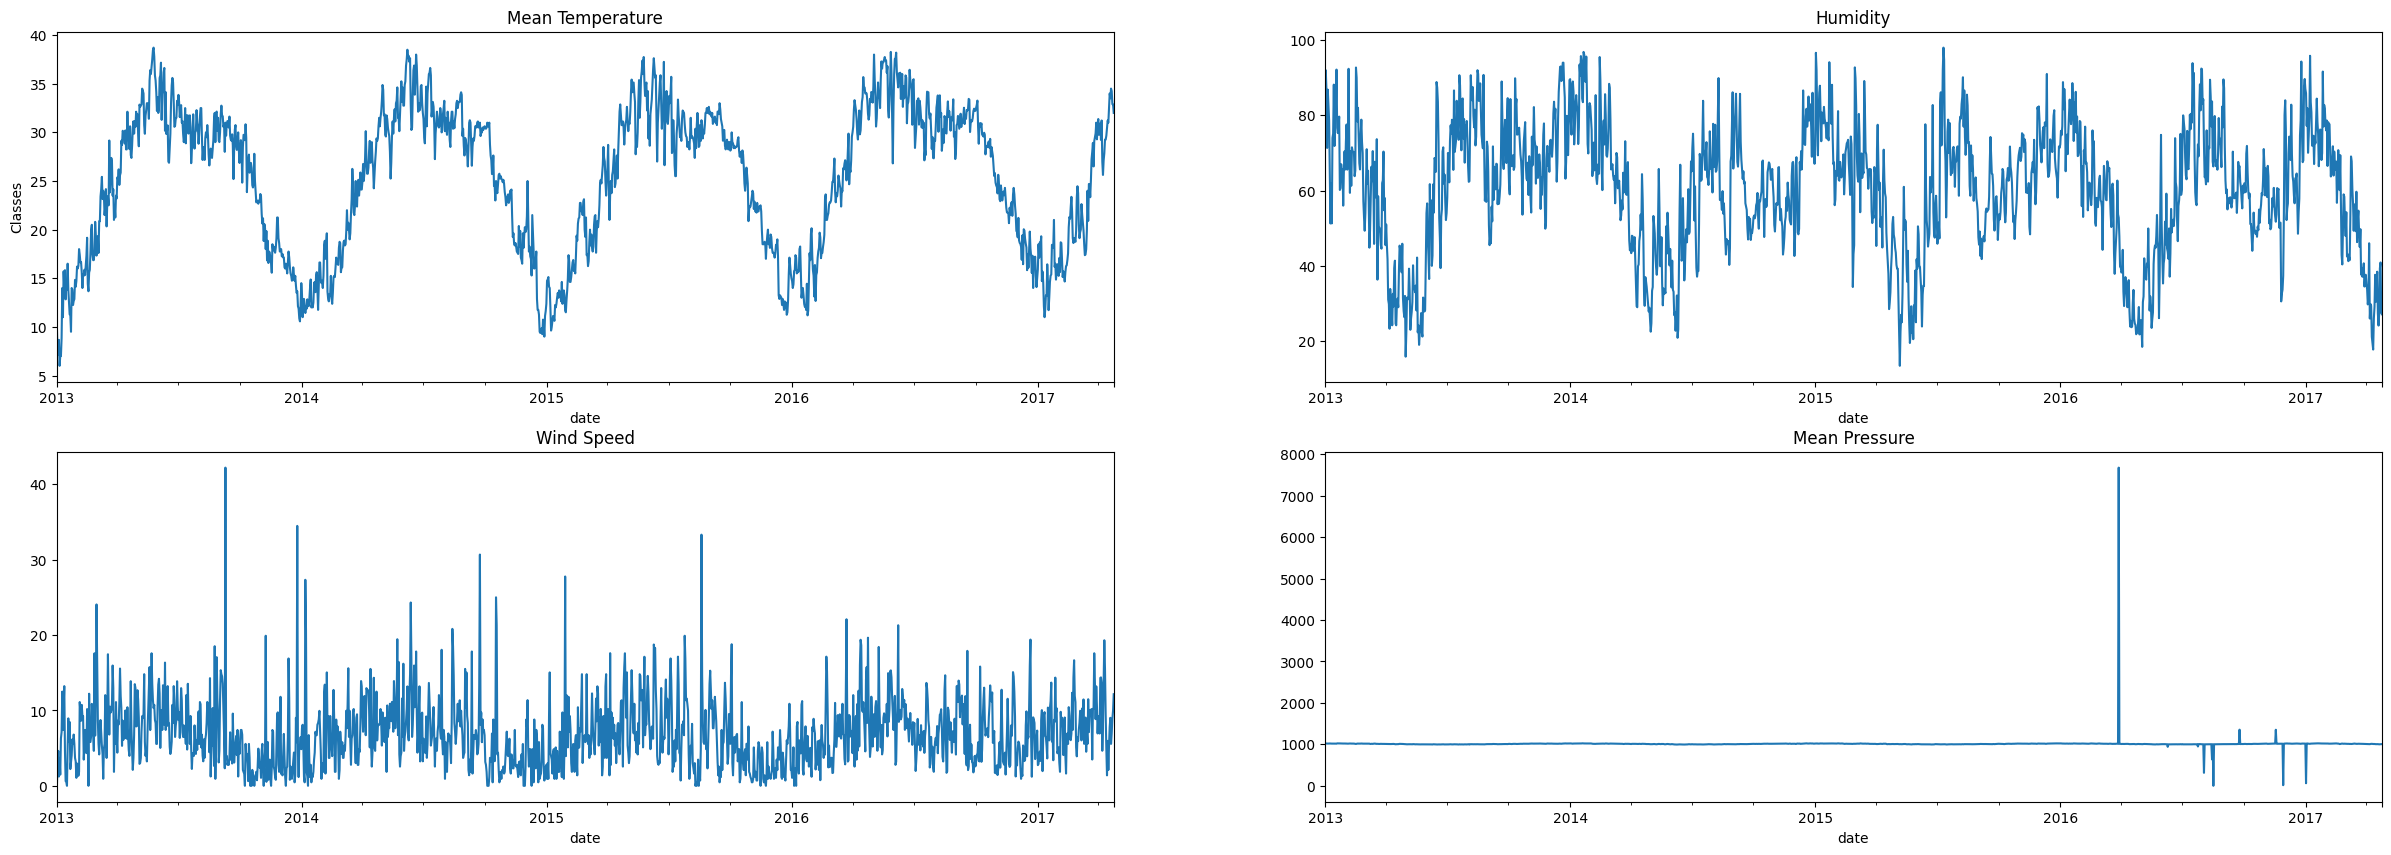

In [3]:
df_total = pd.read_csv(
    "../data/DailyDelhiClimate.csv", parse_dates=True, index_col="date"
)

fig = plt.figure(figsize=(30, 10))
rows = 2
columns = 2

ax1 = fig.add_subplot(rows, columns, 1)
ax1.set_title("Mean Temperature")
plt.ylabel("Classes")
df_total["meantemp"].plot()

ax1 = fig.add_subplot(rows, columns, 2)
ax1.set_title("Humidity")
df_total["humidity"].plot()

ax1 = fig.add_subplot(rows, columns, 3)
ax1.set_title("Wind Speed")
df_total["wind_speed"].plot()

ax1 = fig.add_subplot(rows, columns, 4)
ax1.set_title("Mean Pressure")
df_total["meanpressure"].plot()

plt.show()

Boxplots of training and test data after removal of outliers

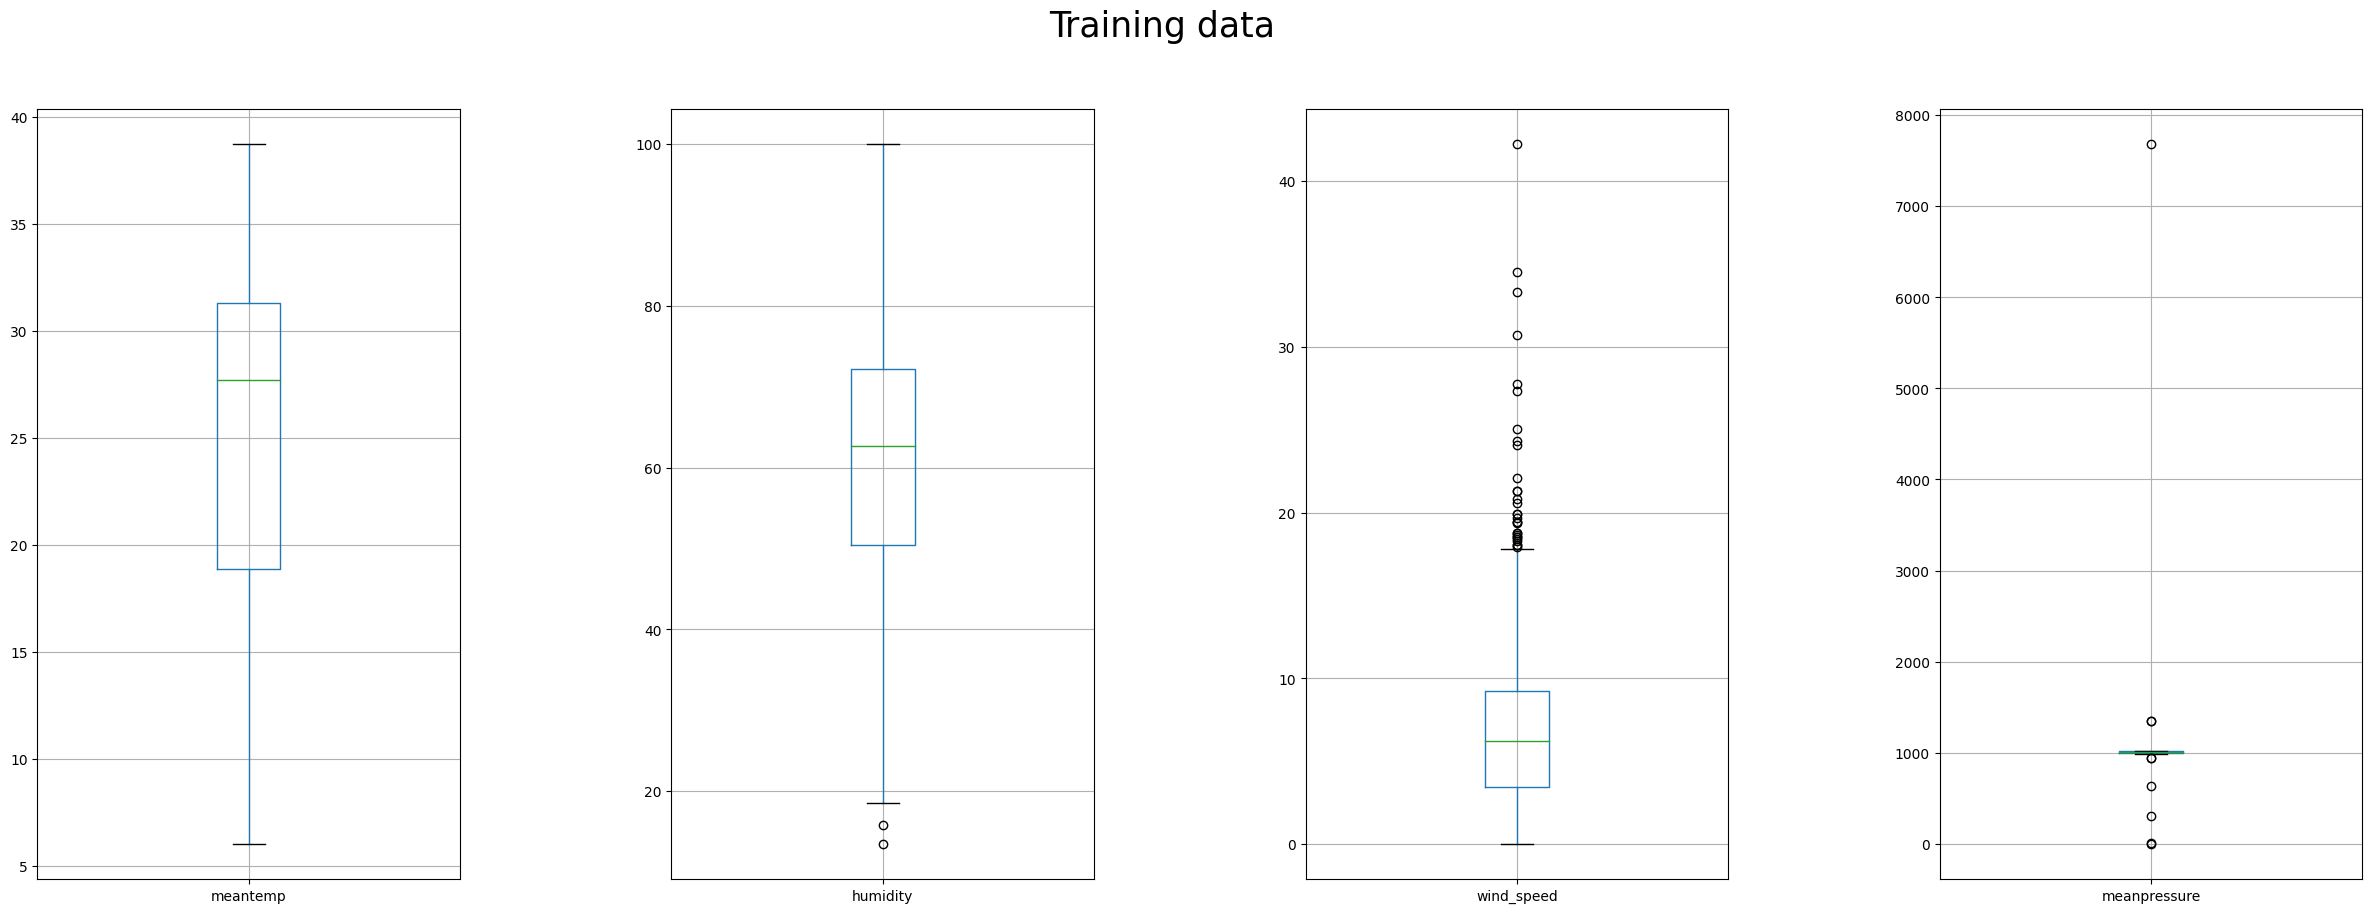

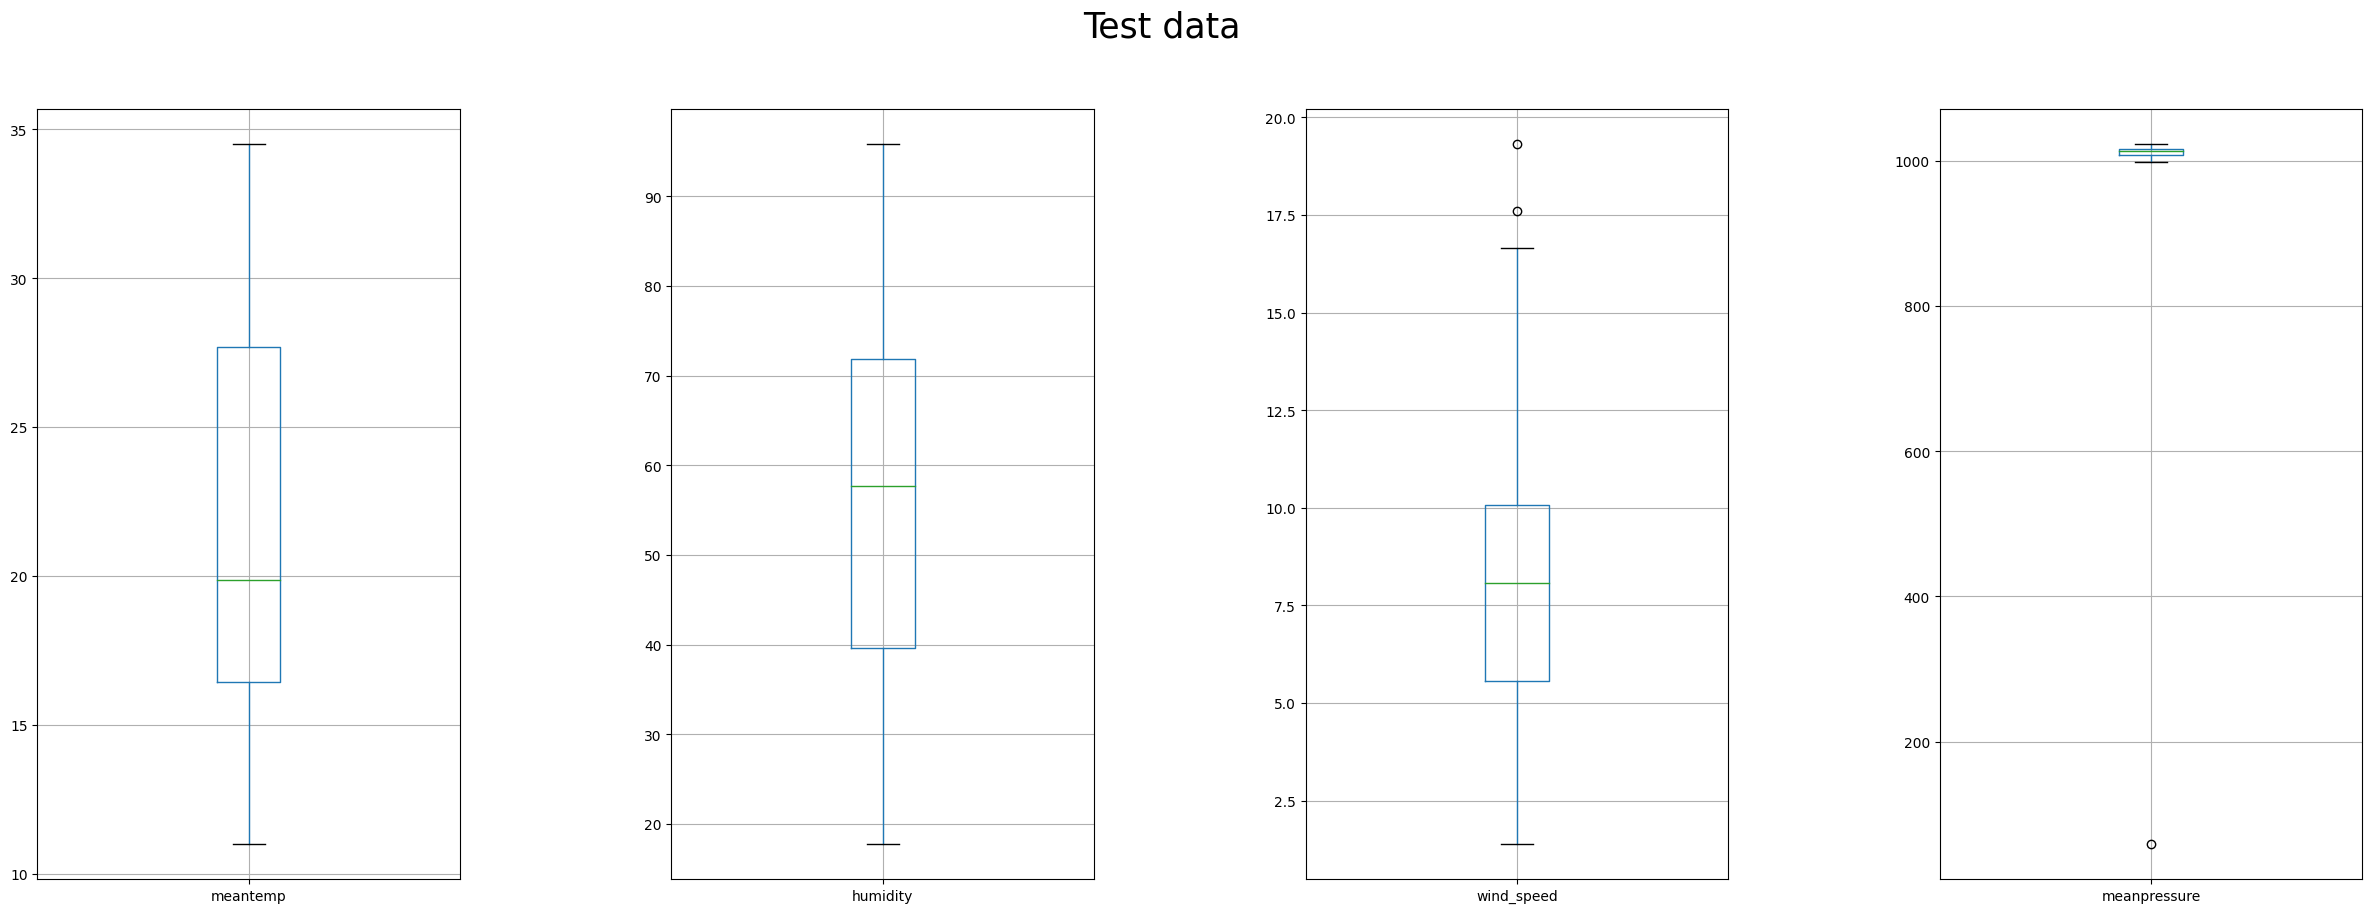

In [4]:
# Creation of boxplots for train data
fig, ax = plt.subplots(1, 4, figsize=(30, 10))

df_train.boxplot("meantemp", ax=ax[0])
df_train.boxplot("humidity", ax=ax[1])
df_train.boxplot("wind_speed", ax=ax[2])
df_train.boxplot("meanpressure", ax=ax[3])

plt.subplots_adjust(wspace=0.5)

plt.suptitle("Training data", fontsize=25)
plt.show()

# Creation of boxplots for test data
fig, ax = plt.subplots(1, 4, figsize=(30, 10))

df_test.boxplot("meantemp", ax=ax[0])
df_test.boxplot("humidity", ax=ax[1])
df_test.boxplot("wind_speed", ax=ax[2])
df_test.boxplot("meanpressure", ax=ax[3])

plt.suptitle("Test data", fontsize=25)
plt.subplots_adjust(wspace=0.5)

plt.show()

Removal of outliers using interquantile range (IQR)

In [5]:
# Removal of outliers in the train set
Q1_train = df_train.quantile(0.25)
Q3_train = df_train.quantile(0.75)
IQR_train = Q3_train - Q1_train

df_train = df_train[
    ~(
        (df_train < (Q1_train - 1.5 * IQR_train))
        | (df_train > (Q3_train + 1.5 * IQR_train))
    ).any(axis=1)
]

# Removal of outliers in the test set
Q1_test = df_test.quantile(0.25)
Q3_test = df_test.quantile(0.75)
IQR_test = Q3_test - Q1_test

df_test = df_test[
    ~(
        (df_test < (Q1_test - 1.5 * IQR_test)) | (df_test > (Q3_test + 1.5 * IQR_test))
    ).any(axis=1)
]

Boxplots of training and test data after removal of outliers

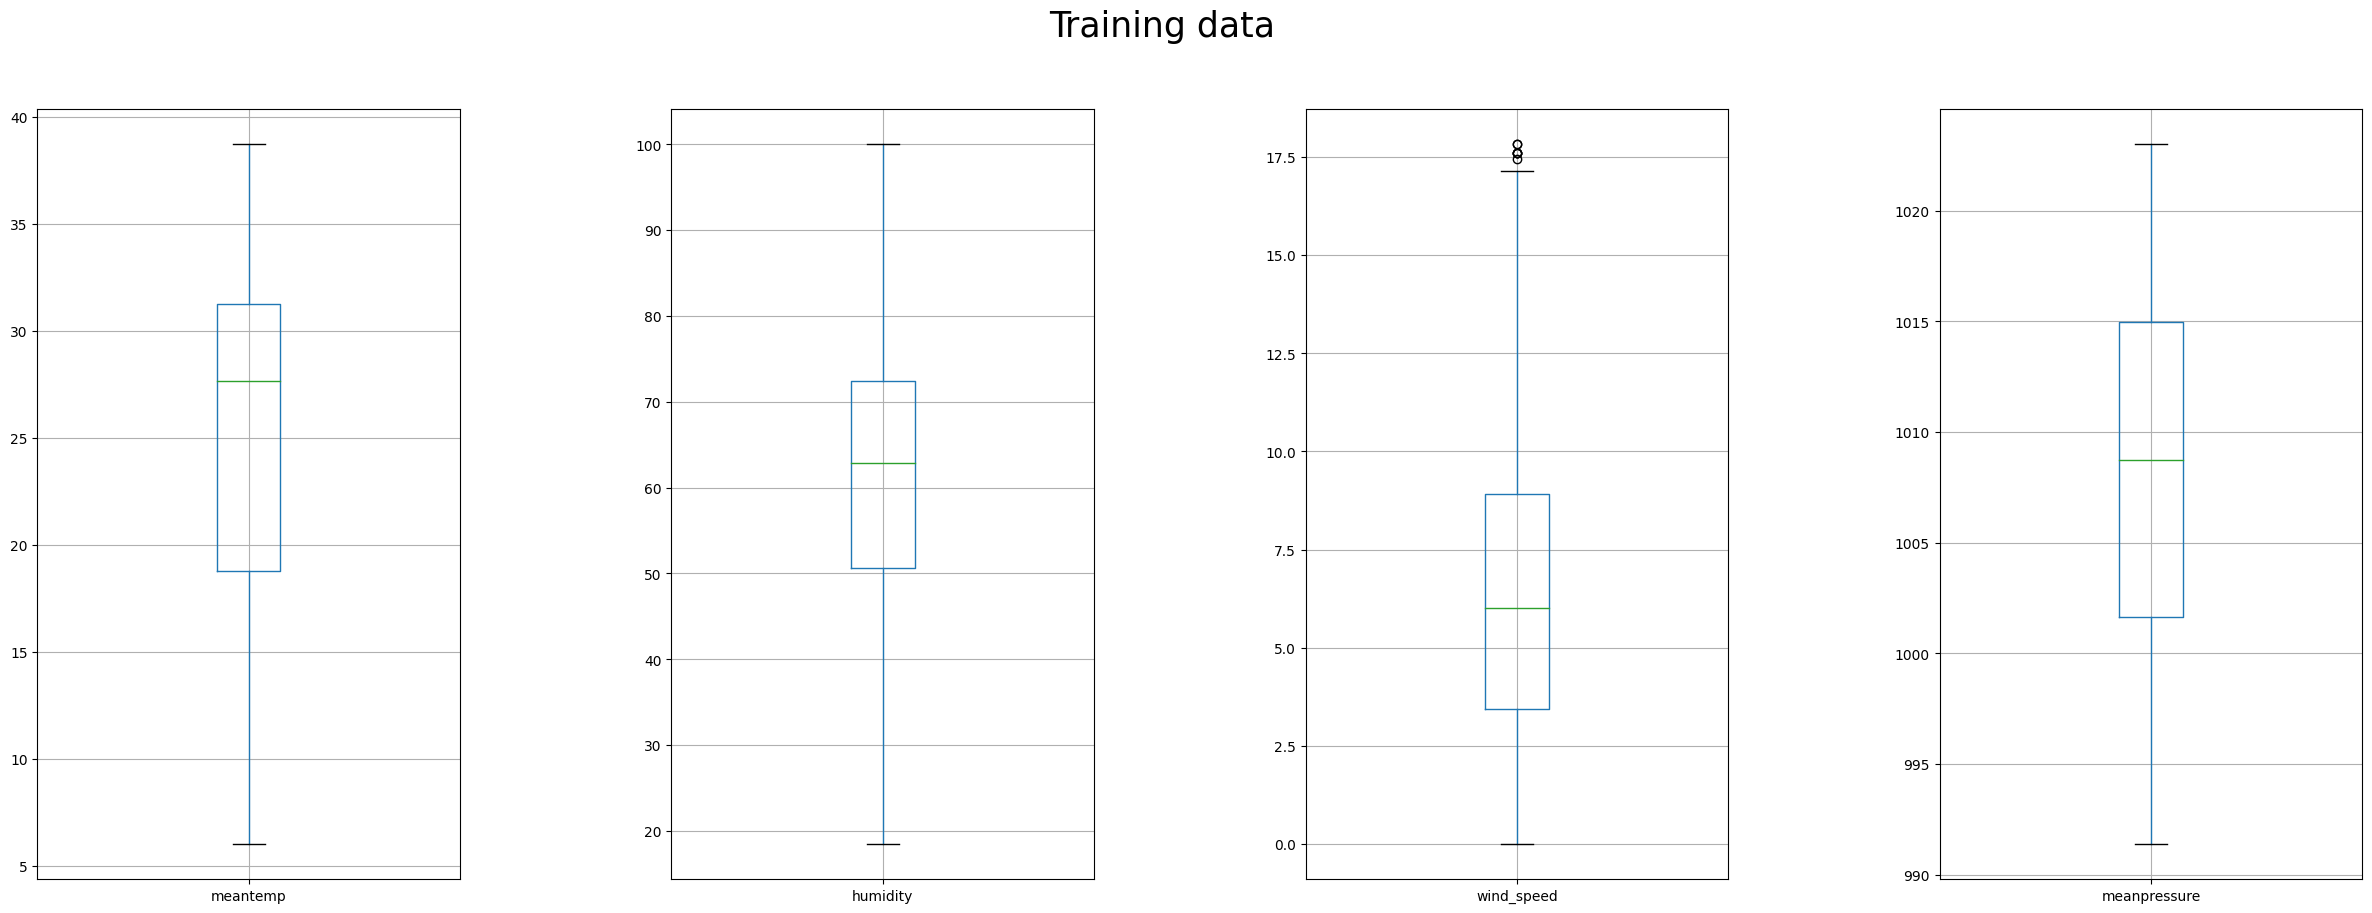

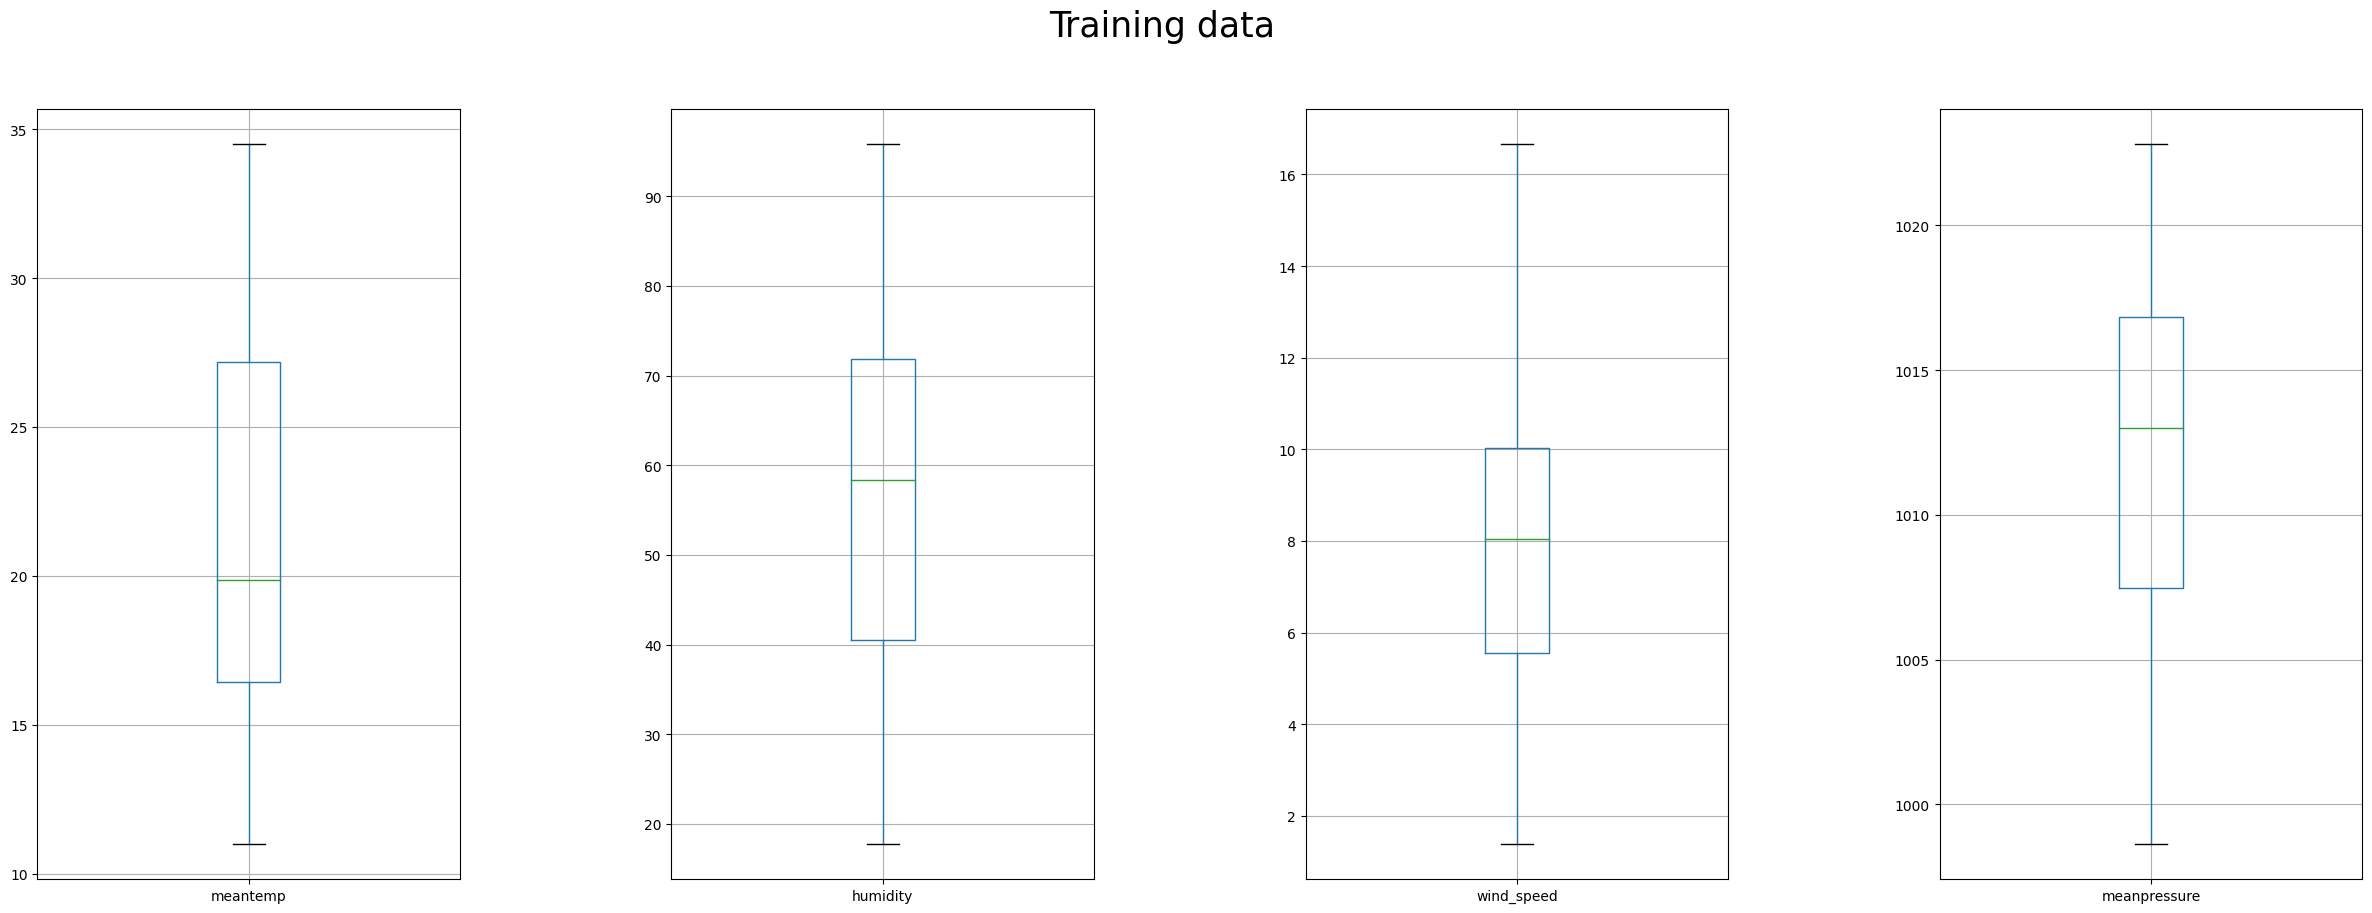

In [6]:
# Creation of boxplots for train data
fig, ax = plt.subplots(1, 4, figsize=(30, 10))

df_train.boxplot("meantemp", ax=ax[0])
df_train.boxplot("humidity", ax=ax[1])
df_train.boxplot("wind_speed", ax=ax[2])
df_train.boxplot("meanpressure", ax=ax[3])

plt.suptitle("Training data", fontsize=25)
plt.subplots_adjust(wspace=0.5)

plt.show()

# Creation of boxplots for test data
fig, ax = plt.subplots(1, 4, figsize=(30, 10))

df_test.boxplot("meantemp", ax=ax[0])
df_test.boxplot("humidity", ax=ax[1])
df_test.boxplot("wind_speed", ax=ax[2])
df_test.boxplot("meanpressure", ax=ax[3])

plt.suptitle("Training data", fontsize=25)
plt.subplots_adjust(wspace=0.5)

plt.show()

In [7]:
target_col = "meantemp"
feature_cols = ["humidity", "wind_speed", "meanpressure"]

y_train = df_train[target_col]
X_train = df_train[feature_cols]
y_test = df_test[target_col]
X_test = df_test[feature_cols]

In [8]:
print(df_train.head())
print(df_test.head())

             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2017-01-02  18.500000  77.222222    2.894444   1018.277778
2017-01-03  17.111111  81.888889    4.016667   1018.333333
2017-01-04  18.700000  70.050000    4.545000   1015.700000
2017-01-05  18.388889  74.944444    3.300000   1014.333333
2017-01-06  19.318182  79.318182    8.681818   1011.772727


# Modelling
In this section we compute our Gaussian Process Models. We define some helper functions to facilitate the process 🙌 

In [9]:
def create_gp_plot(X_test, y_test, gp_mean, st_dev):
    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

    # realizations in the background
    ax1.fill_between(
        X_test,
        gp_mean - 0 * st_dev,
        gp_mean + 0 * st_dev,
        color="red",
        alpha=0.05,
        label="$2 \sigma$",
    )
    for i in range(1, 5):
        ax1.fill_between(
            X_test,
            gp_mean - 0.5 * i * st_dev,
            gp_mean + 0.5 * i * st_dev,
            color="red",
            alpha=0.05,
        )

    # confidence interval of 2 stdev

    ax1.plot(X_test, gp_mean, "r-", lw=2, label="$\mu^{*}$")
    ax1.plot(X_test, y_test, "ko", linewidth=2, label="$(x_n, y_n)$")
    ax1.set_xlabel("$x$")
    ax1.set_ylabel("$f(x)$")
    ax1.set_title("Gaussian Process Regression")
    # ax1.axis([domain[0], domain[1], -3, 3])
    ax1.legend(loc=2)
    return fig

## Basic Model
We start with a very simple Model using a `RBF` kernel and assess its performance. We set `n_restarts_optimizer=10` and `alpha=0.5`.

The noise level in the targets can be specified by passing it via the parameter `alpha`, either globally as a scalar or per datapoint. Note that a moderate noise level can also be helpful for dealing with numeric issues during fitting as it is effectively implemented as Tikhonov regularization, i.e., by adding it to the diagonal of the kernel matrix

In [10]:
model = gp.GaussianProcessRegressor(
    kernel=RBF(), n_restarts_optimizer=10, alpha=0.5, normalize_y=True
)

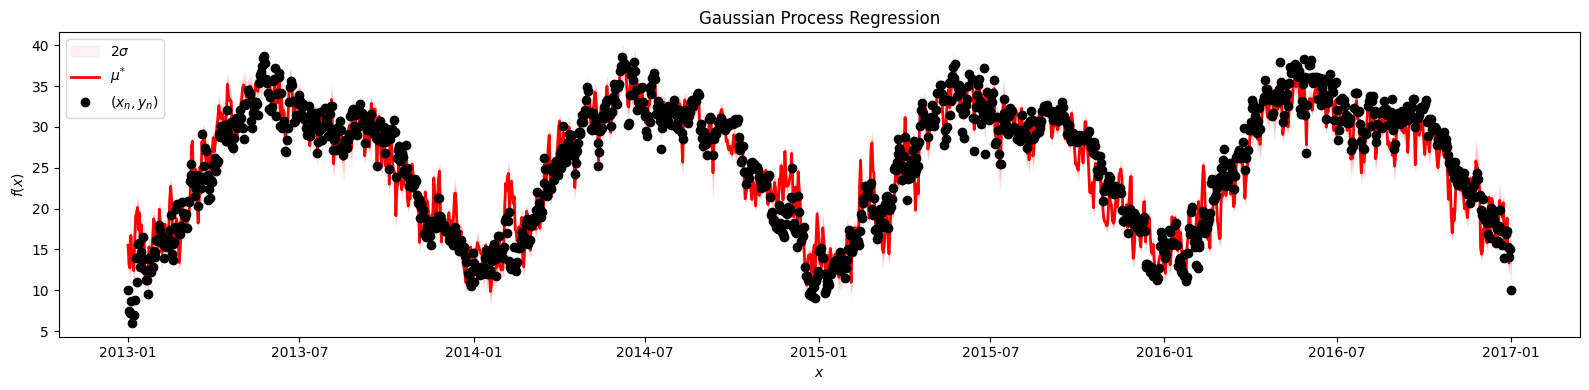

In [11]:
model.fit(X_train, y_train)

y_pred, std = model.predict(X_train, return_std=True, return_cov=False)
gp_mean = model.predict(X_train)

fig = create_gp_plot(X_train.index.to_list(), y_train, gp_mean, std)
plt.tight_layout()
plt.show()

In [12]:
model.score(X_train, y_train)

0.8933227641419494

By using simple techniques, our model is already able to identify seasonal trends. The graph shows $\mu^*$ derived from the predictions of `X_test`. It yields a $R^2$ of 0.89 👏 However, it is more advisable to assess model performance using a test dataset.

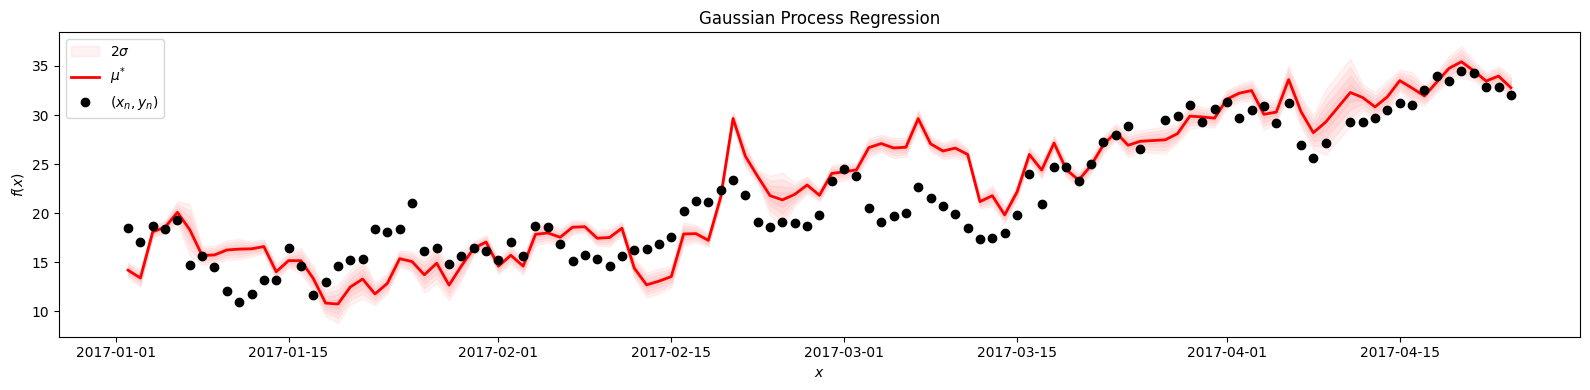

In [13]:
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [14]:
baseline = model.score(X_test, y_test)
print(baseline)

0.7525884334224979


A $R^2$ of 0.73 👍 

Not bad, but let's see if we can do better by adjusting some hyperparameters.

## Testing different Models
Gaussian Processes allow for the integration of prior knowledge or expert beliefs into the prediction process. By specifying informative priors or using appropriate kernel functions, GPs can incorporate known information about the underlying data structure. This property is especially useful in situations where domain expertise or external factors play a significant role in the time series behavior. By combining prior knowledge with observed data, Gaussian Processes enhance the accuracy and reliability of predictions.
`sklearn` does not support providing a prior, as it focuses on custom kernel functions. We will use this approach in the following code cells 💪

### White-Noise-Kernel
We can combine White-Noise-Kernels with RBF to capture smooth and continous variations over time. White-Noise-Kernels can help to tackle noisy observations and are therefore an alternative to the `alpha` parameter.
A small constant $σ_n^2$ is customarily added to the diagonal of the covariance matrix $Σ$:

$Σ←Σ+σ^2_nI$

The constant $σ_n^2$ is interpreted as the variance of observation noise, normally distributed with zero mean. Instead of adding the noise to the covariance matrix, a white noise kernel term can be added to the process kernel. 

In [15]:
kernel = RBF() + WhiteKernel(noise_level=1, noise_level_bounds=(0.1**2, 0.5**2))
model = gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)
model.fit(X_train, y_train)
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

/home/lukas/.local/share/virtualenvs/prob-ml-project-acRXiJBF/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.010000000000000002. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


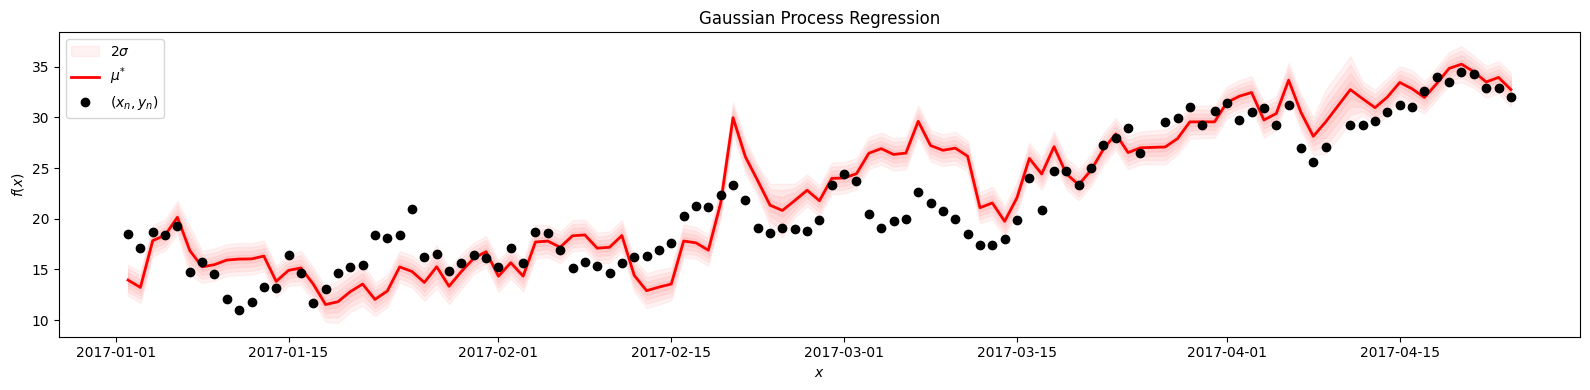

In [16]:
fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [17]:
score = model.score(X_test, y_test)
print(score)
print(f"Current Score - Baseline Score = {score - baseline}")

0.7583990516255331
Current Score - Baseline Score = 0.005810618203035189


It delivers more or less the same performance as our baseline model. We played around wit the `noise_level` parameter a little bit to achieve better results. In general, our dataset is not very noisy, which is why `noise_level` converges to our defined lower level bound:

In [18]:
model.kernel_.get_params()["k2__noise_level"]

0.010000000000000004

### ExpSineSquared
Since we look at temperature data, it may be useful to include a periodic kernel for seasonal variability.
The ExpSineSquared kernel allows one to model functions which repeat themselves exactly. It is parameterized by a length scale parameter $l > 0$ and a periodicity parameter $p > 0$.

In [19]:
kernel = RBF() + WhiteKernel(noise_level=0.1) + ExpSineSquared(length_scale=1.0)

model = gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)
model.fit(X_train, y_train)
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

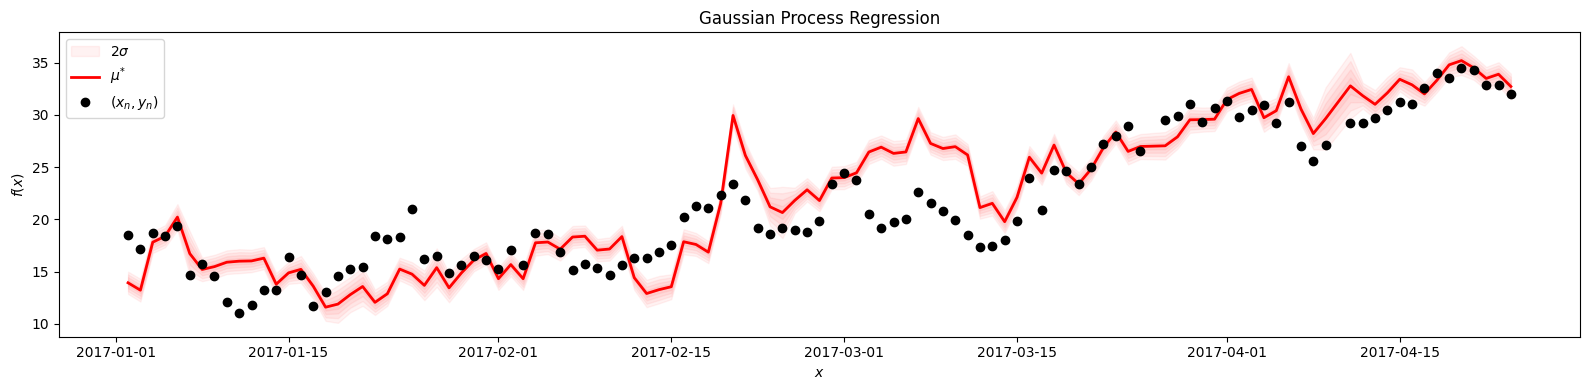

In [20]:
fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [21]:
score = model.score(X_test, y_test)
print(score)
print(f"Current Score - Baseline Score = {score - baseline}")

0.7583926798098144
Current Score - Baseline Score = 0.00580424638731647


We're getting closer to our baseline now!
### ConstantKernel
A different approach could be to use a constant kernel that incorporates temperature increase caused by climate change.

In [22]:
kernel = RBF() + WhiteKernel(noise_level=0.1) + ConstantKernel(constant_value=0.01)

model = gp.GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True
)
model.fit(X_train, y_train)
y_pred, std = model.predict(X_test, return_std=True, return_cov=False)
gp_mean = model.predict(X_test)

/home/lukas/.local/share/virtualenvs/prob-ml-project-acRXiJBF/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


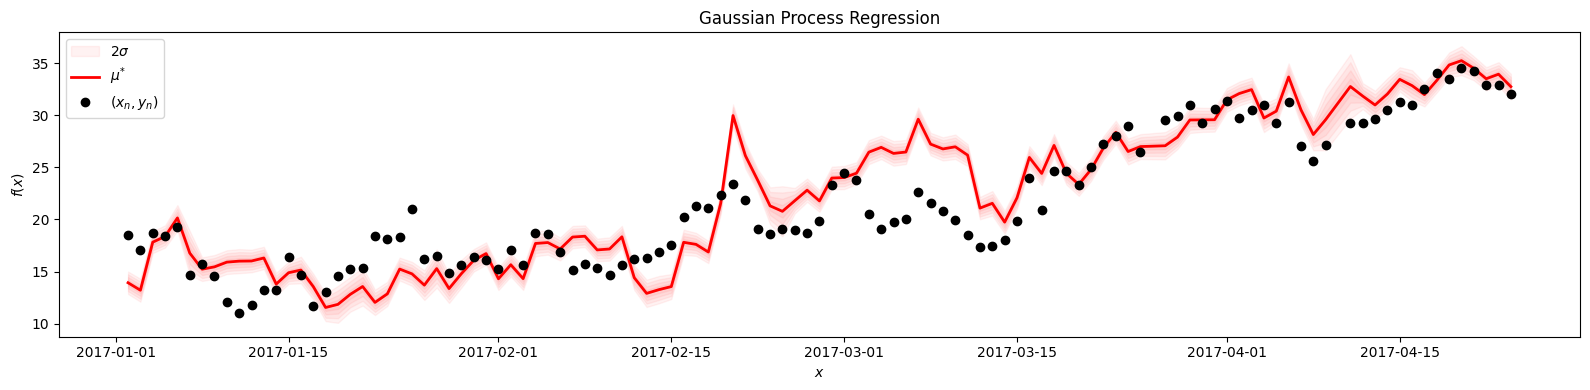

In [23]:
fig = create_gp_plot(X_test.index.to_list(), y_test, gp_mean, std)
plt.tight_layout()
plt.show()

In [24]:
score = model.score(X_test, y_test)
print(score)
print(f"Current Score - Baseline Score = {score - baseline}")

0.7585868819342343
Current Score - Baseline Score = 0.005998448511736365


# Conclusion
Tuning our model did not help much - performance seems to converge at $R^2 = 0.73$. The benefit of incorporating custom kernels still was demonstrated: expert knowledge can be used to improve model performance by adjusting kernels.

Additionally, Gaussian Processes provide confidence intervals that come in handy for model interpretability.